# Segment Building Footprints in Zanzibar

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import fastai
print(fastai.__version__)

1.0.30


## Load Data

In [4]:
path = Path('/storage/znz-segment/znz-train-z19-all-buffered')
path.ls()

[PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/.DS_Store'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/valid.txt'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512'),
 PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512')]

In [5]:
path_lbl = path/'masks-512'
path_img = path/'images-512'

In [6]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_036_19_319455_270721_img.jpg'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_058_19_319438_270866_img.jpg'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/images-512/grid_001_19_319372_270499_img.jpg')],
 [PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_001_19_319373_270494_mask_buffered.png'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_029_corrected_19_319458_270686_mask_buffered.png'),
  PosixPath('/storage/znz-segment/znz-train-z19-all-buffered/masks-512/grid_001_19_319370_270506_mask_buffered.png')])

In [7]:
len(fnames), len(lbl_names)

(2691, 2691)

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem.split("_img")[0]}_mask_buffered.png'

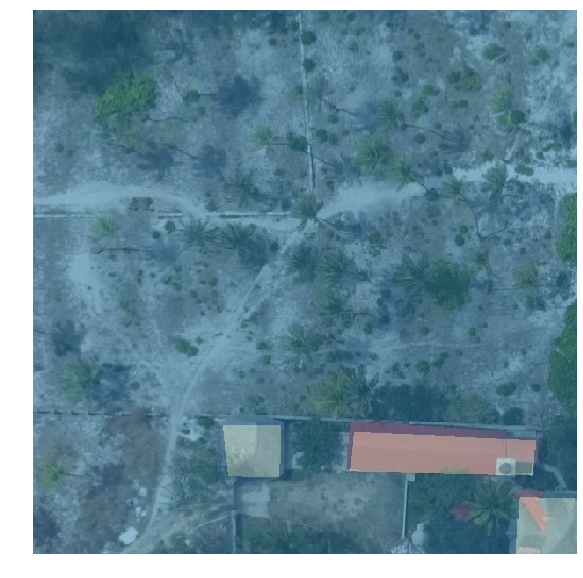

In [9]:
img_f = fnames[0]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [10]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[512 512]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

# Make DataBunch

In [11]:
size = src_size
bs=8

In [12]:
holdout_grids = ['_028_','_029_','_042_','_058_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [13]:
codes = np.array(['Empty','Building'])

In [14]:
# overriding to set open_mask(fn, div=True), probably a better way to do this
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/19

class SegmentationLabelList(ImageItemList):
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat()
        self.c = len(self.classes)

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(ImageItemList): _label_cls = SegmentationLabelList

In [15]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

In [16]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
data

ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (2094 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (2094 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Valid: LabelList
y: SegmentationLabelList (597 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512
x: SegmentationItemList (597 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /storage/znz-segment/znz-train-z19-all-buffered/images-512;
Test: None

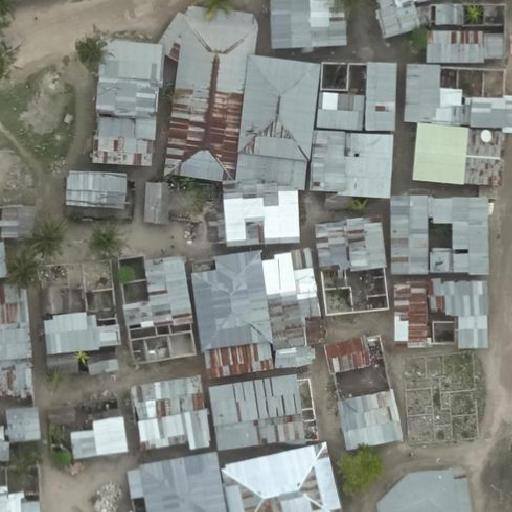

In [18]:
data.train_ds.x[1]

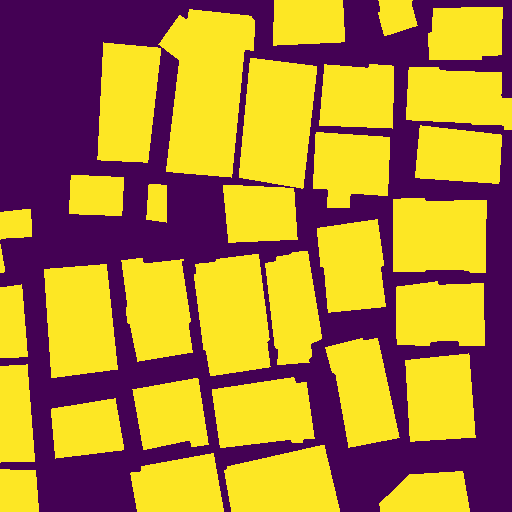

In [19]:
data.train_ds.y[1]

In [20]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]])

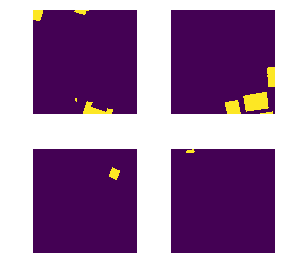

In [21]:
data.show_batch(2,figsize=(4,4))

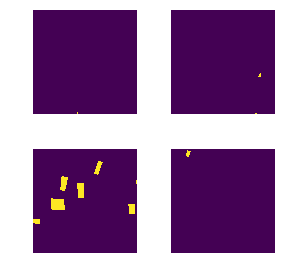

In [22]:
data.show_batch(2,figsize=(4,4), ds_type=DatasetType.Valid)

# Custom Loss

In [23]:
import pdb

In [24]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    
    input = input.sigmoid()
    input = input[:,1,None]
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()    

    return (1 - ((2. * intersection + smooth).float() / 
                 (iflat.sum() + tflat.sum() +smooth)).float())

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat()
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [25]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [26]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [27]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [28]:
learn.loss_func

CrossEntropyFlat()

In [29]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [30]:
# learn.opt_func = partial(optim.SGD,momentum=0.9)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## resnet34, size = 512, bs = 8, loss = combo dice+bce loss

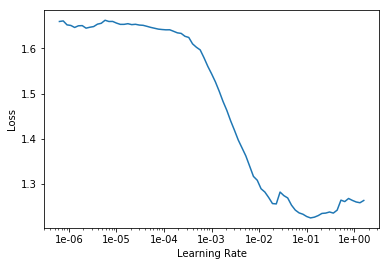

In [40]:
learn.recorder.plot()

In [31]:
from fastai.callbacks import *

In [32]:
learn.fit_one_cycle(10, max_lr=3e-3, 
                    callbacks=[
                        SaveModelCallback(learn,monitor='dice',mode='max',name='20181129-rn34unet-comboloss-z19_512-best')
                    ])

In [33]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [34]:
outputs.shape

torch.Size([8, 2, 512, 512])

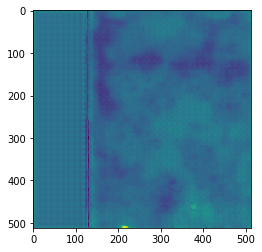

In [35]:
plt.imshow((to_np(outputs[0][1])))

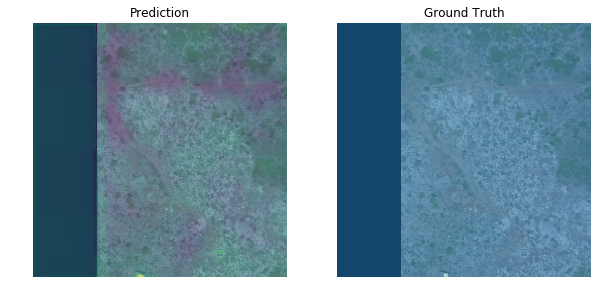

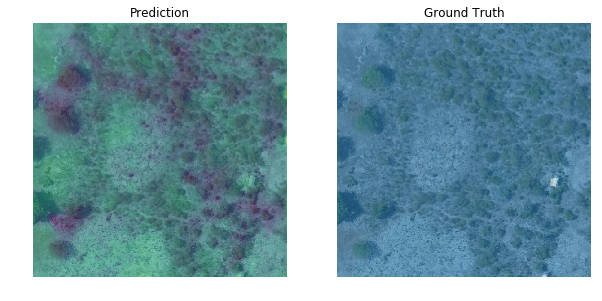

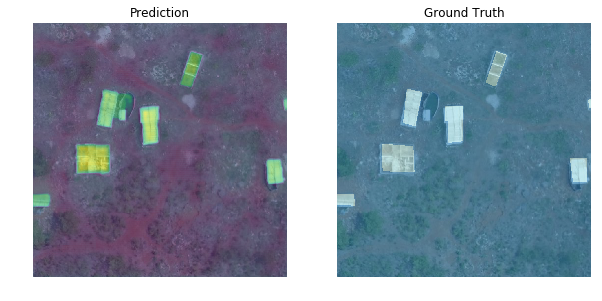

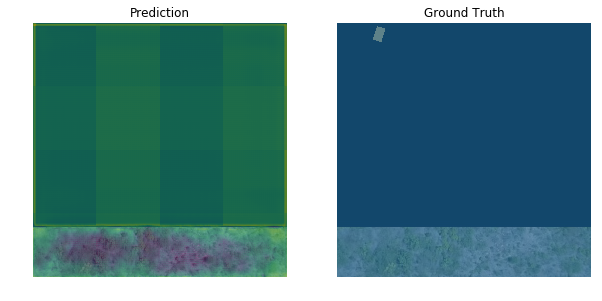

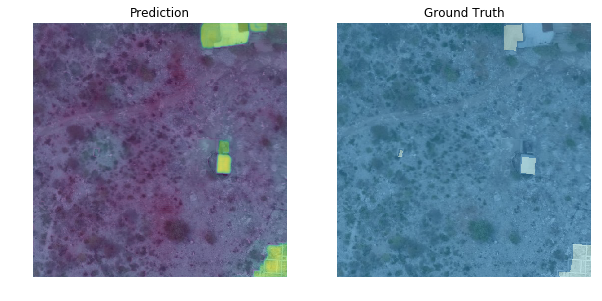

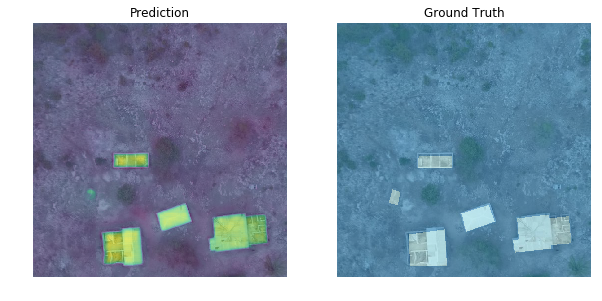

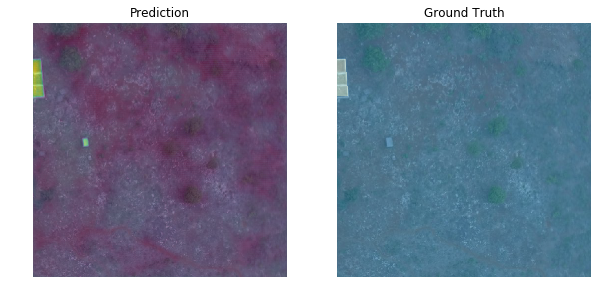

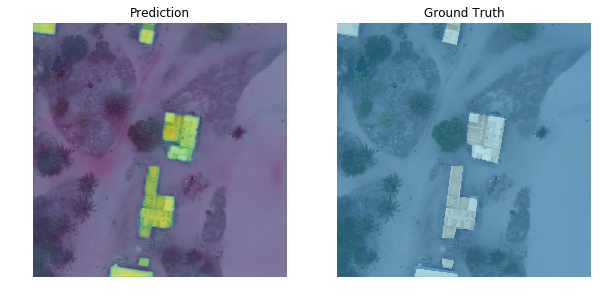

In [36]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


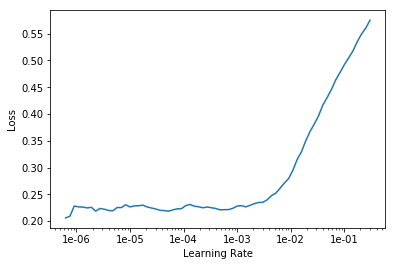

In [38]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-3), 
                    callbacks=[
                        SaveModelCallback(learn,monitor='dice',mode='max',name='20181129-rn34unet-comboloss-z19_512-best')
                    ])

In [42]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [43]:
outputs.shape

torch.Size([8, 2, 512, 512])

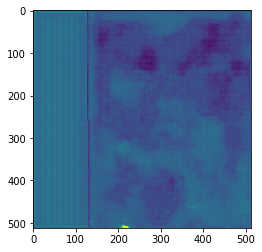

In [44]:
plt.imshow((to_np(outputs[0][1])))

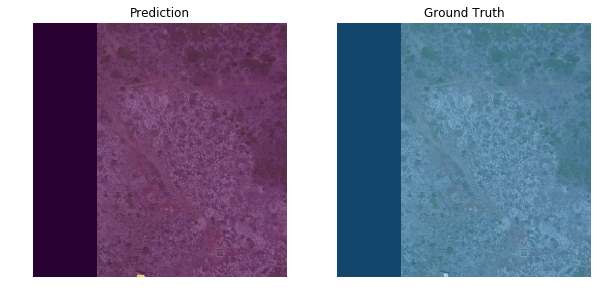

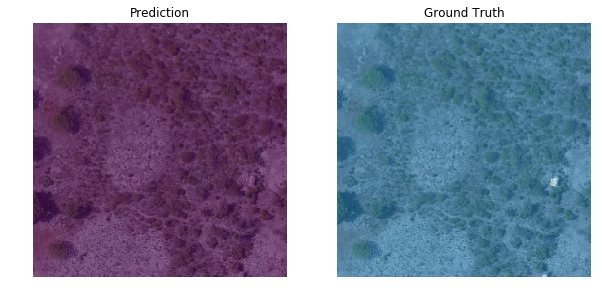

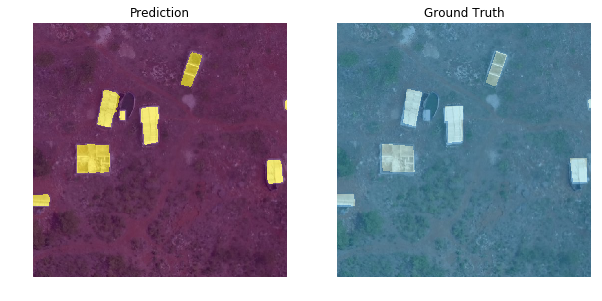

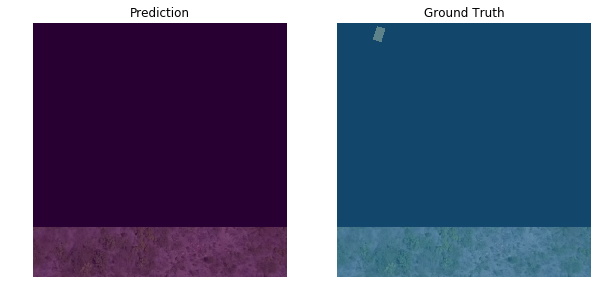

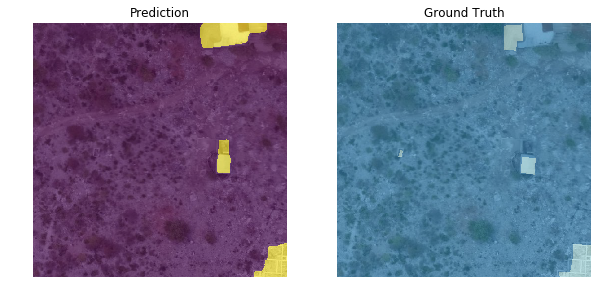

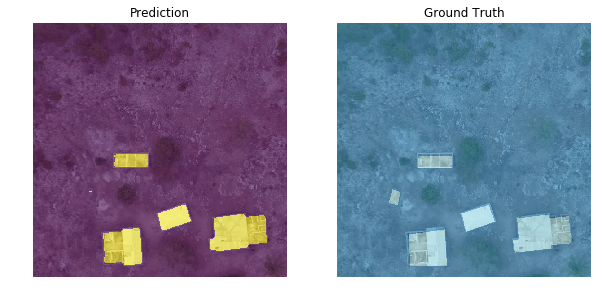

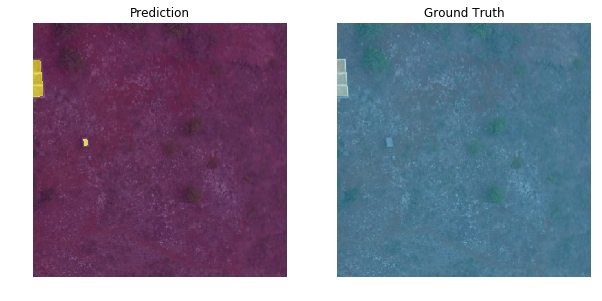

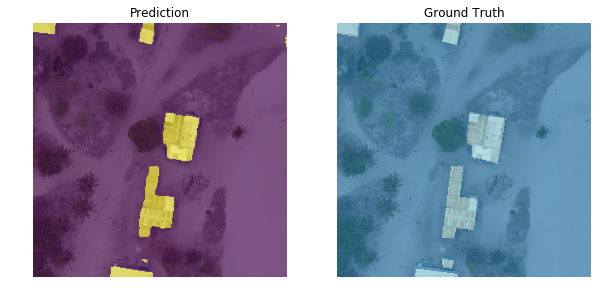

In [46]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])>0.3), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [48]:
learn.load('20181129-rn34unet-comboloss-z19_512-best')
learn.model.train()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


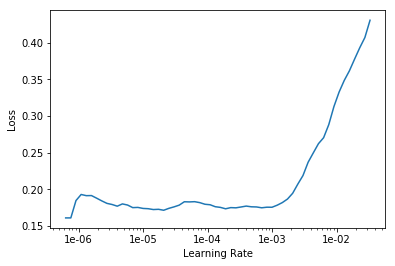

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,(1e-3)/5), 
                    callbacks=[
                        SaveModelCallback(learn,monitor='dice',mode='max',name='20181129-rn34unet-comboloss-z19_512-round2best')
                    ])

In [53]:
learn.load('20181129-rn34unet-comboloss-z19_512-round2best')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [54]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

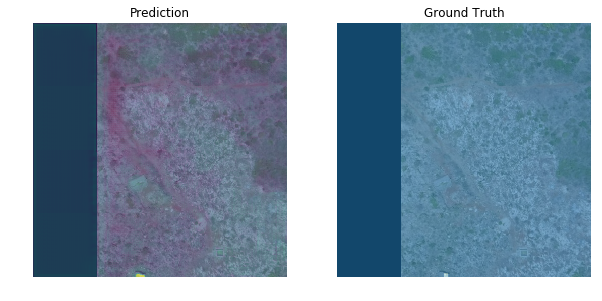

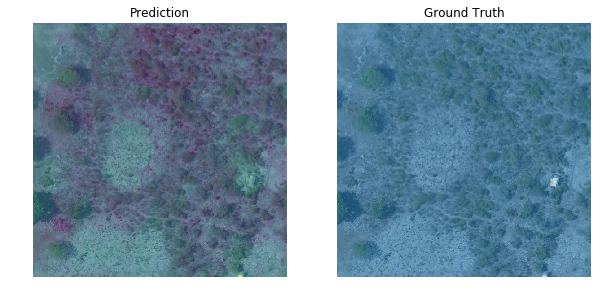

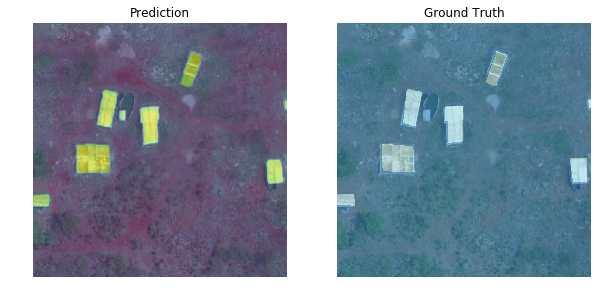

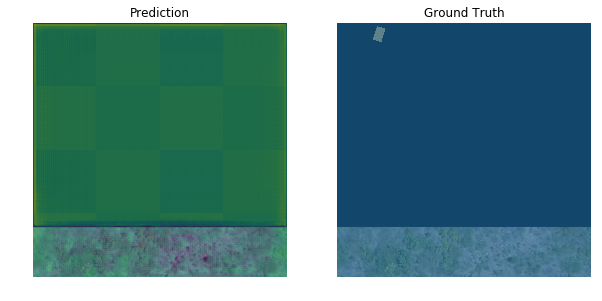

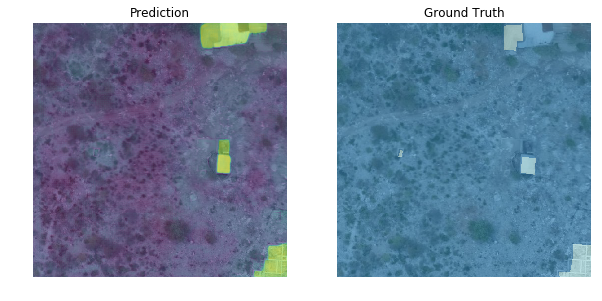

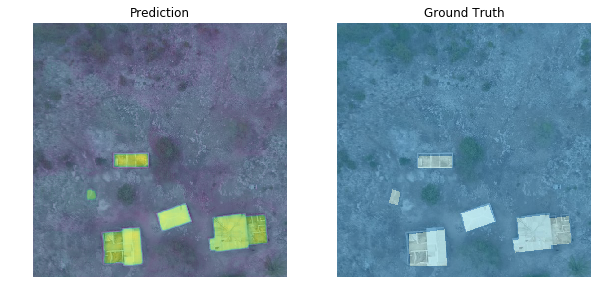

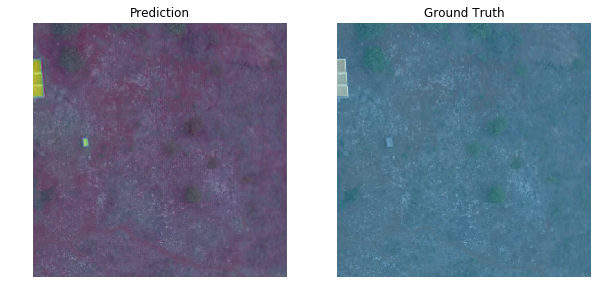

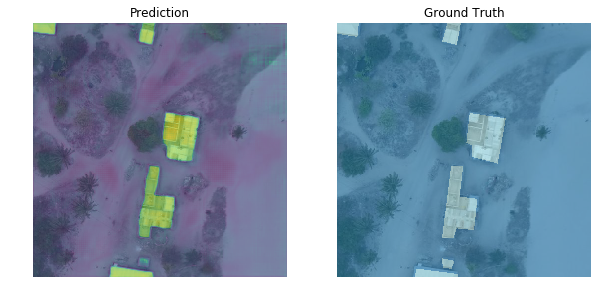

In [56]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()